In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import cvxopt
import cvxpy as cp

# Hard Support Vector Classifier

Assume we have a binary classification data set $(X,y)$ with labels $-1,1$, such that the classes are linearly seperable.
We want to find the seperating hyperplane that maximizimes the distance between the plane and the closest point in the data set. This can be written as
$$\begin{equation*}
    \begin{split}
        \text{maximize} & \qquad r\\
        \text{subject to} & \qquad (H,r) \text{ is a seperating hyperplane, and distance between } x_i \text{ and } H \text { is at least }r \text{ for all } i.
    \end{split}
\end{equation*}$$
Let us see how we can express this as a convex optimization problem.

A seperating hyperplane can be described by a vector $w$ and constant a $b$  such that $\text{sign}(w\cdot x_i - b)=y_i$, or equivalently $y_i (w \cdot x_i - b) >0$ for all $i$. The distance between $x_i$ and the hyperplane is given by
$$\frac{y_i(w \cdot x_i - b)}{||w||} $$
We can write the optimization problem by
$$\begin{equation*}
    \begin{split}
        \text{maximize} & \qquad r\\
        \text{subject to} & \qquad y_i(w \cdot x_i-b) \geq r||w|| \text{ for all } i.
    \end{split}
\end{equation*}$$
We can rescale $w$ and $b$ such that $||w|| r=1$ without changing the optimization problem. Hence, we get the following equivalent convex optimization problem.
$$\begin{equation*}
    \begin{split}
        \text{minimize} & \qquad ||w||^2\\
        \text{subject to} & \qquad y_i(w \cdot x_i-b) \geq 1 \text{ for all } i.
    \end{split}
\end{equation*}$$

# Support Vector Classifier

In the case that the classification set is not linearly seperable, no $(w,b)$ satisfies the constraints above. But, we can still use a similar optimization problem by adding a cost for each constraint which is not satisfied as follows:
$$\text{minimize } ||w||^2 + C\sum_{i=1}^N \max(0,1 - y_i(w \cdot x_i -b)) $$
Here $C$ is a hyperparameter, controling how much punishment we give for unsatisfied constraints. We can convert the optimization problem to a quadratic convex optimization problem by introducing new variables $(a_i)_{i=1}^N$ and writing the problem as
$$\begin{equation*}
    \begin{split}
        \text{minimize} & \qquad ||w||^2+C\sum_{i=1}^N a_i\\
        \text{subject to} & \qquad y_i(w \cdot x_i-b) + a_i \geq 1 \text{ for all } i \\
        & \qquad a_i \geq 0 \text{ for all } i.
    \end{split}
\end{equation*}$$

## Dual Problem

We can understand the solution of the optimization problem better by using duality. By [Slater's condition](https://en.wikipedia.org/wiki/Slater's_condition), strong duality holds. Furthermore, [Karush-Kuhn-Tucker (KKT) conditions](https://en.wikipedia.org/wiki/Karush–Kuhn–Tucker_conditions) provides necessary and sufficient conditions for primary and dual optimal points. The Lagrangian function is given by
$$\begin{equation*}
    \begin{split}
        L(w,b,a, \lambda, \mu) &= \frac{||w||^2}{2}+C\sum_{i=1}^N a_i - \sum_{i=1}^N \lambda_i \big(y_i(w \cdot x_i+b)-(1-a_i)\big) - \sum_{i=1}^N \mu_i a_i
    \end{split}
\end{equation*}$$

We have the following derivatives
$$\begin{equation*}
    \begin{split}
        \nabla_w L &= w - \sum_{i=1}^N \lambda_i y_i\phi(x_i) \\
        \frac{\partial L}{\partial b} &= - \sum_{i=1}^N \lambda_i y_i \\
        \frac{\partial L}{\partial a_i} &= C-(\lambda_i+\mu_i)
    \end{split}
\end{equation*}$$

Karush-Kuhn-Tucker (KKT) conditions for primal and dual optimal points are given by
$$\begin{equation}
    \begin{split}
        &w =  \sum_{i=1}^N \lambda_i y_ix_i \\
        &\sum_{i=1}^N \lambda_i y_i  = 0\\
        &\lambda_i+\mu_i = C \text{ for all } i \\
        &a_i, \lambda_i, \mu_i \geq 0 \text{ for all } i \\
        &\mu_i a_i = 0 \\
        &y_i(w \cdot \phi(x_i)+b) + a_i \geq 1 \text{ for all } i \\
        &\lambda_i \big(y_i(w \cdot x_i)+b)-(1-a_i)\big) = 0 \\
    \end{split}
\end{equation}$$

By plugging in KKT conditions to the Lagrangian, the dual problem becomes:
$$\begin{equation*}
    \begin{split}
        \underset{(\lambda_i)_{i=1}^N \in \mathbb{R}^N}{\text{maximize}} & \qquad \frac{-1}{2}\sum_{i,j} (x_i \cdot x_j) y_i y_j \lambda_i \lambda_j+\sum_{i=1}^N \lambda_i \\
        \text{subject to} & \qquad 0 \leq  \lambda_i \leq C \text{ for all } i \\
        &\qquad \sum_{i=1}^N \lambda_i y_i  = 0
    \end{split}
\end{equation*}$$

## Support Vectors

Let $(w,b,(a_i))$ be the primal optimal point. A training point $x_i$ is called a support vector if $y_i(w \cdot x_i + b) \leq 1$. If $x_i$ is not a support vector, then by the last KKT condition $\lambda_i = 0$.  Combining this with the first KKT condition, we see that $w, b$ are completely determined by support vectors. More precisely,
$$\begin{equation*}
    \begin{split}
        w &= \sum_{i, \lambda_i \neq 0}\lambda_i y_i x_i \\
        b &= -y_i - w \cdot x_i \text{ for any } i \text{ such that } \lambda_i \neq 0, C
    \end{split}
\end{equation*}$$

## Implementation of Support Vector Classifier

In [2]:
class SVC:
    def __init__(self,C=1):
        self.C=C
    def fit(self,X,y):
        #introduce to variables for optimization
        N, p = X.shape
        w = cp.Variable(p+1)
        a = cp.Variable(N)
        #objective function
        objective = cp.Minimize(sum([w[i]**2 for i in range(p)])+self.C*sum(a))
        #constraints
        B=(y*np.concatenate((X,np.ones((X.shape[0],1))),axis=1).T).T
        constraints = [B@w+a>=1, a>=0]
        #solve the optimization problem
        prob = cp.Problem(objective, constraints)
        prob.solve()
        self.coefs = w.value
        
    def predict(self,X):
        N = X.shape[0]
        X_aug = np.concatenate((X,np.ones((N,1))),axis=1)
        return 2*(X_aug @ self.coefs > 0)-1

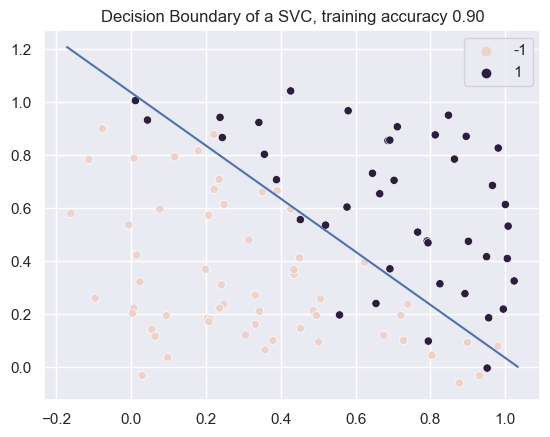

In [3]:
#create a 2D dataset
np.random.seed(13)
N=100
X_true = np.random.uniform(0,1,(N,2))
X = X_true + 0.1*np.random.randn(N,2)
y=2*(X_true.sum(axis=1)>1)-1
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y);

#fit a SVC
C=5
svc = SVC(C)
svc.fit(X,y)
y_pred=svc.predict(X)
acc=(y_pred == y).mean()


#plot the seperating line
w=svc.coefs
xs=np.linspace(X[:,0].min()-0.01,X[:,0].max()+0.01,101)
ys=[(-w[2]-w[0]*x)/w[1] for x in xs]
sns.lineplot(x=xs,y=ys)
plt.title(f'Decision Boundary of a SVC, training accuracy {acc:.2f}');

# Support Vector Machine

If decision boundary is not linear, one can still use SVC by embedding the data set in a higher dimensional space. Let $\mathcal{H}$ be a Hilbert space and $\phi: \mathbb{R}^p \to \mathcal{H}$ be an embedding. Let $K(x,x')=\phi(x) \cdot \phi(x')$. $K$ is called the kernel function. The dual problem becomes
$$\begin{equation*}
    \begin{split}
        \underset{(\lambda_i)_{i=1}^N \in \mathbb{R}^N}{\text{maximize}} & \qquad \frac{-1}{2}\sum_{i,j} K(x_i,x_j) y_i y_j \lambda_i \lambda_j+\sum_{i=1}^N \lambda_i \\
        \text{subject to} & \qquad 0 \leq  \lambda_i \leq C \text{ for all } i \\
        &\qquad \sum_{i=1}^N \lambda_i y_i  = 0
    \end{split}
\end{equation*}$$
Let $(w,b,(a_i))$ and $(\lambda_i)$ be primal and dual solutions. Then we have
$$\begin{equation*}
    \begin{split}
        w &= \sum_{i, \lambda_i \neq 0}\lambda_i y_i \phi(x_i) \\
        b &= -y_i - \sum_{j, \lambda_j \neq 0}\lambda_j y_jK(x_i,x_j) \text{ for any } i \text{ such that } \lambda_i \neq 0, C
    \end{split}
\end{equation*}$$
Note that for any $x \in \mathbb{R}^p$, we have
$$w \cdot \phi(x) := \sum_{i, \lambda_i \neq 0} \lambda_i y_i K(x,x_i) $$
Hence, just the kernel function is enough for implementing SVM.

## Radial Basis Function Kernel

Let us show that $K(x,y)=e^{-||x-y||^2/2}$ can be used as a kernel function. It is called the radial basis function kernel. We first introduce some notation. Given $\mathbf{n}=(n_1,\dots,n_p) \in \mathbb{Z}_{\geq 0}^p$, $x=(x_1,\dots,x_p)$ and $y=(y_1,\dots,y_p)$ in $\mathbb{R}^p$, we define 
- $\mathbf{n}! = \prod_{i=1}^p n_i!$
- $x^\mathbf{n}=\prod_{i=1}^p x_i^{n_i}$
- $x \otimes y=(x_1y_1,\dots,x_py_p)$
- $x^2 = x \otimes x$
With this notation, one can show the following equality:
$$e^{x \cdot y} = \sum_{\mathbf{n} \in \mathbb{Z}_{\geq 0}^p} \frac{(x \otimes y)^\mathbf{n}}{\mathbf{n}!} $$
Now, let $\mathcal{H}$ denote the Hilbert space 
$$\mathcal{H}=\{(a_\mathbf{n})_{\mathbf{n} \in \mathbb{Z}_{\geq 0}^p}: \quad \sum_{\mathbf{n} \in \mathbb{Z}_{\geq 0}^p} a_\mathbf{n}^2 < \infty \}$$
endowed with the inner product
$$\mathbf{a} \cdot \mathbf{b} = \sum_{\mathbf{n} \in \mathbb{Z}_{\geq 0}^p} a_{\mathbf{n}}b_{\mathbf{n}}$$
If we use the embedding $\phi: \mathbb{R}^p \to \mathcal{H}$ given by
$$\phi(x) = e^{-||x||^2/2}\left(\frac{x^\mathbf{n}}{\sqrt{\mathbf{n}!}}\right)_{\mathbf{n} \in \mathbb{Z}_{\geq 0}^p}, $$
we get
$$\begin{equation*}
    \begin{split}
        K(x,y) &= e^{-||x||^2/2} e^{-||y||^2/2} \sum_{\mathbf{n} \in \mathbb{Z}_{\geq 0}^p} \frac{(x \otimes y)^\mathbf{n}}{\mathbf{n}!} \\
          &= e^{-||x||^2/2} e^{-||y||^2/2} e^{x \cdot y} \\
          &= e^{-||x-y||^2/2}
    \end{split}
\end{equation*}$$

# Implementation of Support Vector Machine

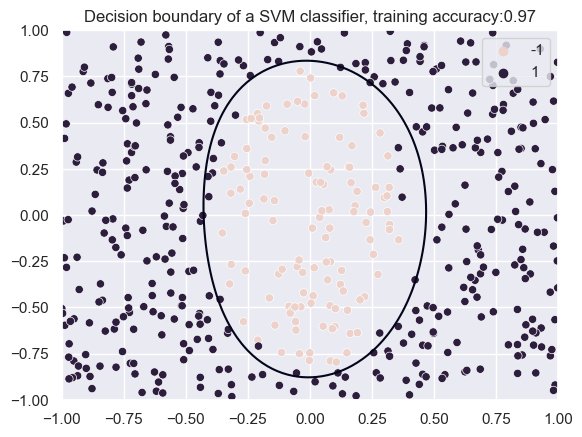

In [4]:
class SVM:
    def __init__(self,kernel='radial',C=1.0):
        if kernel=='radial':
            kernel = lambda x,y : np.exp(-(x-y)@(x-y)/2)
        self.kernel = kernel
        self.C=C
    def fit(self,X,y,verbose=False):
        #Kernel values for data points
        K = np.array([[self.kernel(x,y) for x in X] for y in X])
        
        #set up the dual problem
        N = X.shape[0]
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(N) * -1)
        A = cvxopt.matrix(1.0*y, (1, N))
        b = cvxopt.matrix(0.0)
        G = cvxopt.matrix(np.vstack((-1.0*np.eye(N),1.0*np.eye(N))))
        h = cvxopt.matrix(np.hstack((np.zeros(N), self.C*np.ones(N))))
        
        # Solve the dual problem:
        cvxopt.solvers.options['show_progress'] = verbose
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        #compute and record info needed for predictions
        lambdas = np.ravel(solution['x'])
        support_indices = lambdas>1e-5
        proper_indices = (lambdas>1e-5) & (lambdas<self.C-1e-5)
        self.support_vectors = X[support_indices]
        self.signed_lambdas = y[support_indices]*lambdas[support_indices]
        self.b=(-y[proper_indices]
                -(K[proper_indices][:,support_indices]@self.signed_lambdas)).mean()
    def project(self,X):
        #this is the function whose sign determine the prediction
        K = np.array([[self.kernel(x,y) for y in self.support_vectors] for x in X])
        return K@self.signed_lambdas+self.b
    def predict(self,X):
        return 2*(self.project(X)>0)-1
#create a data set
np.random.seed(13)
N=500
X=np.random.uniform(-1,1,(N,2))
y=2*((5*X[:,0]**2+X[:,1]**2)>0.7)-1
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y)

#fit a SVM
svm=SVM(C=20)
svm.fit(X,y)

#find training accuracy
y_pred=svm.predict(X)
acc = (y_pred == y).mean()

#plot the decision boundary
def project(x0,x1):
    X=np.array([[x0,x1]])
    return svm.project(X)[0]
xs=np.linspace(-1,1,100)
ys=np.linspace(-1,1,100)
Z=[[project(x,y) for x in xs] for y in ys]
plt.contour(xs,ys,Z,[0])
plt.title(f'Decision boundary of a SVM classifier, training accuracy:{acc:.2f}');